In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
from google.colab import files
# Subir tu archivo kaggle.json
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s3e20

In [5]:
import zipfile
import os
zip_filename = 'playground-series-s3e20.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()
#files = os.listdir()
#files

preprocesado

In [6]:
## KEEPOUTPUT
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar as pbar
from local.lib import mlutils
%matplotlib inline
d = pd.read_csv("train.csv")
d.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


valores faltantes

In [21]:
## KEEPOUTPUT
k = d.isna().sum()
k[k!=0]

SulphurDioxide_SO2_column_number_density          14609
SulphurDioxide_SO2_column_number_density_amf      14609
SulphurDioxide_SO2_slant_column_number_density    14609
SulphurDioxide_cloud_fraction                     14609
SulphurDioxide_sensor_azimuth_angle               14609
                                                  ...  
Cloud_surface_albedo                                484
Cloud_sensor_azimuth_angle                          484
Cloud_sensor_zenith_angle                           484
Cloud_solar_azimuth_angle                           484
Cloud_solar_zenith_angle                            484
Length: 70, dtype: int64

In [20]:
k

ID_LAT_LON_YEAR_WEEK            0
latitude                        0
longitude                       0
year                            0
week_no                         0
                             ... 
Cloud_sensor_azimuth_angle    484
Cloud_sensor_zenith_angle     484
Cloud_solar_azimuth_angle     484
Cloud_solar_zenith_angle      484
emission                        0
Length: 76, dtype: int64

In [6]:
## KEEPOUTPUT
def plot_missing(col, target):

    def f1():
        if d[col].dtype==object:
            k = d[col].fillna("missing").value_counts()
            sns.barplot(k.index, k.values)
        else:
            sns.distplot(d[col].dropna())
        plt.title("distribution of %s"%col)
        plt.grid()

    def f2():
        if d[col].dtype==object:
            k=d[[col,target]].dropna()
            for v in d[col].dropna().unique():
                if sum(k[col]==v)>1:
                    sns.distplot(k[target][k[col]==v],
                                 hist_kws=dict(alpha=.3),
                                 kde_kws=dict(linewidth=1, alpha=.8),
                                 label=v);
            if sum(d[col].isna())>1:
                sns.distplot(d[target][d[col].isna()],
                             hist_kws=dict(alpha=.8),
                             kde_kws=dict(linewidth=1, alpha=1),
                             label="missing")
            plt.legend();
        else:
            plt.scatter(d[col], d[target], alpha=.5)
            plt.xlabel(target)
            plt.ylabel(col)
        plt.grid()
        plt.title("%s vs target"%(col))

    def f3():
        n = np.sum(d[col].isna())
        if n>1:
            sns.distplot(d[target][d[col].isna()], color="red",  hist_kws=dict(alpha=.3), label="missing (%d values)"%n)
        sns.distplot(d[target][~d[col].isna()], color="blue",  hist_kws=dict(alpha=.3), label="ok (%d values)"%(len(d)-n))
        plt.title("distribution of target wrt %s"%col)
        plt.yticks([])
        plt.grid()
        plt.legend()

    mlutils.figures_grid(3,1, [f1, f2, f3], figsize=(20,3))

In [7]:
## KEEPOUTPUT
for col in k[k!=0].index:
    plot_missing(col, target="emission")

Output hidden; open in https://colab.research.google.com to view.

In [8]:
def xdistplot(k, title="", xlim=None):
    vals = k
    sns.distplot(k, hist_kws={"alpha": .8});
    m,s = np.mean(vals), np.std(vals)
    plt.axvline(m, color="black", lw=2, alpha=.5)
    plt.axvline(m+s, color="red", lw=2, alpha=.5)
    plt.axvline(m-s, color="red", lw=2, alpha=.5)
    x = np.linspace(np.min(vals), np.max(vals), 100)
    plt.title(title)
    plt.grid();
    if xlim is not None:
        plt.xlim(xlim)

In [9]:
def subs_policies(d, col):
    mcol = "%s_missing"%col
    dn = d.T.dropna().T
    dn = dn[[i for i in dn.columns if d[i].dtype!=object]]
    print (dn.shape)

    na_idxs = np.argwhere(d[col].isna().values)[:,0]

    dl0 = dn.copy()
    dlm = dn.copy()
    dlr = dn.copy()

    dl0[mcol] = d[col].fillna(0)
    dlm[mcol] = d[col].fillna( d[col].mean())

    k = d[col].copy()
    k[k.isna()] = np.random.normal(loc=np.mean(k), scale=np.std(k), size=np.sum(k.isna()))
    dlr[mcol] = k

    f0 = lambda: xdistplot(d[col].dropna(), "original", [0,150])
    f1 = lambda: xdistplot(dl0[mcol], "subs by zero", [0,150])
    f2 = lambda: xdistplot(dlm[mcol], "subs by mean", [0,150])
    f3 = lambda: xdistplot(dlr[mcol], "subs by equivalent normal", [0,150])

    mlutils.figures_grid(4,1, [f0, f1, f2, f3], figsize=(20,3))
    return dn, dl0, dlm, dlr, na_idxs

(79023, 5)


<ipython-input-8-44e0e1649163>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(k, hist_kws={"alpha": .8});
<ipython-input-8-44e0e1649163>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(k, hist_kws={"alpha": .8});
<ipython-input-8-44e0e1649163>:3: UserWarning: 

`distplot` is a deprecated func

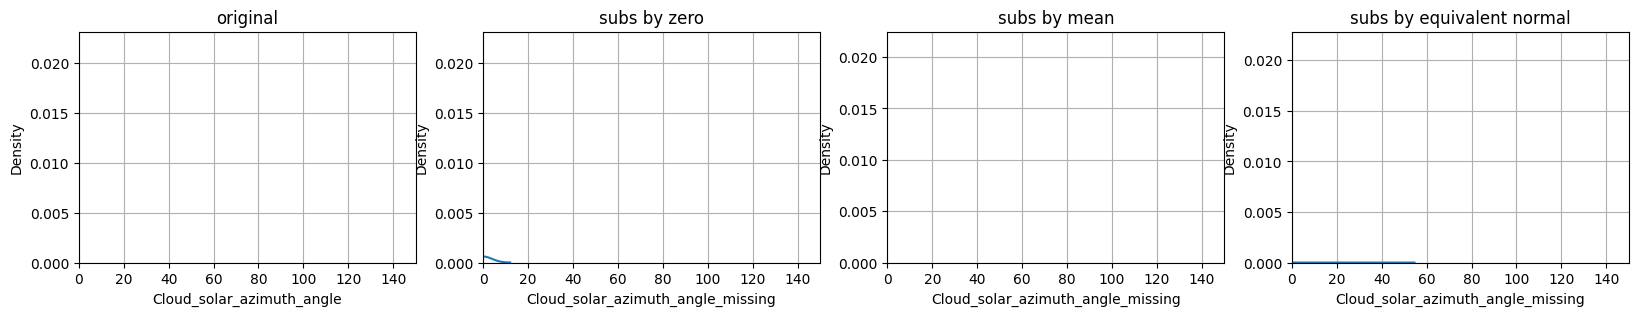

In [23]:
## KEEPOUTPUT
dn, dl0, dlm, dlr, na_idxs = subs_policies(d, "Cloud_solar_azimuth_angle")

In [30]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import ttest_ind

def getXY (dn):
    xcols = [i for i in dn.columns if i!="emission"]
    X = dn[xcols].values.astype(float)
    y = dn.emission.values.astype(float)
    return X,y,xcols

def experiment(dn, estimator, n_models=20, test_size=.3):
    X,y,_ = getXY(dn)
    r = cross_val_score(estimator, X, y, cv=ShuffleSplit(n_models, test_size=test_size),
                        scoring=make_scorer(mean_absolute_error))
    return r

def HTest(ref_dataset, h_datasets, n_models=30, experiment=experiment, **kwargs):
    estimator = RandomForestRegressor(n_estimators=20)
    re = [experiment(i, estimator, n_models=n_models, **kwargs) for i in pbar([ref_dataset]+h_datasets)]

    for r in re[1:]:
        print (ttest_ind(re[0],r))

In [31]:
## KEEPOUTPUT
dl0.head()

,latitude,longitude,year,week_no,emission,Cloud_solar_azimuth_angle_missing
0,-0.51,29.29,2019,0,3.750994,-138.786423
1,-0.51,29.29,2019,1,4.025176,-145.183930
2,-0.51,29.29,2019,2,4.231381,-142.519545
3,-0.51,29.29,2019,3,4.305286,-132.665828
4,-0.51,29.29,2019,4,4.347317,-141.509805


In [32]:
## KEEPOUTPUT
HTest(dn, [dl0, dlm, dlr], n_models=50)

100% (4 of 4) |##########################| Elapsed Time: 0:13:37 Time:  0:13:37


TtestResult(statistic=-40.42855245127819, pvalue=6.209936878531892e-63, df=98.0)
TtestResult(statistic=-40.82614024150257, pvalue=2.5100687419774747e-63, df=98.0)
TtestResult(statistic=-44.369910629566085, pvalue=1.0893037162534456e-66, df=98.0)


Eliminar columnas que tienen muy bajo grado de correlación con la variable objetivo

In [7]:
columnas_a_eliminar = ['SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_sensor_zenith_angle']
d = d.drop(columnas_a_eliminar, axis=1)


eliminar los demas valores faltantes con datos generados de una distribucion normal

In [8]:
import pandas as pd
import numpy as np

# Supongamos que tu DataFrame se llama 'df'
# Rellenar valores faltantes con una distribución normal
d = d.apply(lambda x: x.fillna(np.random.normal(x.mean(), x.std()) if x.dtype != 'O' else x))

# Guardar los cambios si es necesario
d.to_csv('nuevo_conjunto_de_datos.csv', index=False)


In [9]:
## KEEPOUTPUT
k = d.isna().sum()
k[k!=0]

Series([], dtype: int64)